In [1]:
using TickTock
ENV["TICKTOCK_MESSAGES"] = false;

### Wtih JuMP

In [3]:
using JuMP , Ipopt
include("../Problems/JuMP/rocket_JMP.jl")
RocketJMP = rocket_JMP();

set_optimizer(RocketJMP,Ipopt.Optimizer)
set_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"tol",1e-8)
set_optimizer_attribute(RocketJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RocketJMP,"max_iter",1000)
tick();
optimize!(RocketJMP)
t1 = tok();
objective_value(RocketJMP)

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
N = 100;
Δt = RocketJMP[:step]; 
h = RocketJMP[:h];
v = RocketJMP[:v];
m = RocketJMP[:m];
T = RocketJMP[:T];
Δtt = value.(Δt)
t = Vector((0:N)*Δtt);
hh = Vector(value.(h)) ;
vv = Vector(value.(v)) ;
mm = Vector(value.(m)) ;
TT = Vector(value.(T)) ;

x =  [ [ hh[i], vv[i], mm[i] ] for i in 1:N+1 ];


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



### With OptimalControl

In [2]:
using OptimalControl
include("../Problems/OptimalControl/rocket_OC.jl")
RocketOC = rocket_OC()
tick();
sol = OptimalControl.solve(RocketOC,display=false);
t2 = tok();

### Compair results

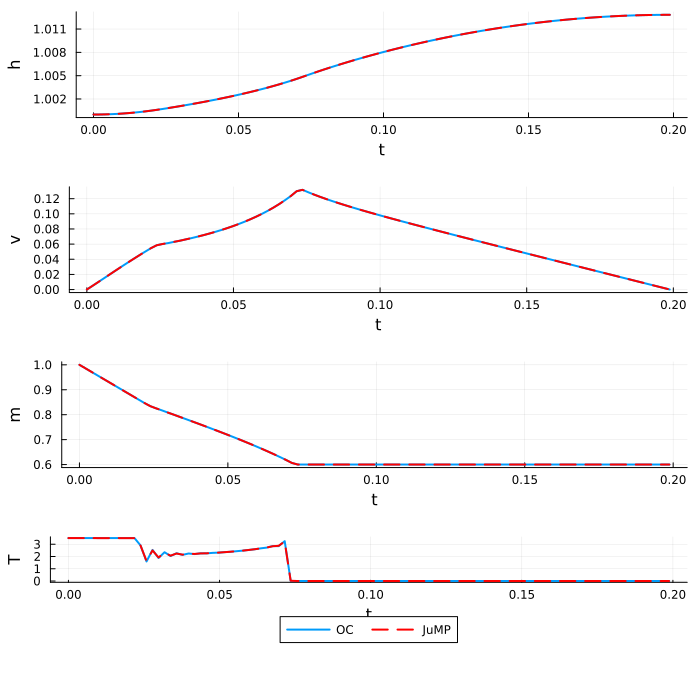

In [4]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[2],line = 2)
p2 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[3],line = 2)
p3 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[7] , label ="OC",line = 2)
p4 = plot!(t, [ TT[i] for i in 1:N+1 ], xlabel = "t", ylabel = "T", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p4 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a; b; c; d]

x_plot = plot(p1, p2, p3, p4, layout = layout)
x_plot = plot!(size = (700, 700))

display(x_plot)

In [5]:
using DataFrames
results = DataFrame( :method => String[], 
                :nvar => Int64[],
                :ncon => Int64[],
                :niter => Int64[],
                :nonzero_jac => Int64[],
                :nonzero_hess => Int64[],
                :diff_auto_time => Float64[] , 
                :total_time => Float64[],
                :objective_value => Float64[],
            );
push!(results,[ "JuMP" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);
push!(results,[ "OptimalControl" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);


In [6]:
function jac_hess_nnz_JMP(model)
    nlp = MOI.Nonlinear.Model()
    for (F, S) in list_of_constraint_types(model)
        if F <: VariableRef
            continue
        end
        for ci in all_constraints(model, F, S)
            object = constraint_object(ci)
            MOI.Nonlinear.add_constraint(nlp, object.func, object.set)
        end
    end
    MOI.Nonlinear.set_objective(nlp, objective_function(model))
    evaluator = MOI.Nonlinear.Evaluator(
        nlp,
        MOI.Nonlinear.SparseReverseMode(),
        index.(all_variables(model)),
    )
    MOI.initialize(evaluator, MOI.features_available(evaluator))
    nnz_hess = length(MOI.hessian_lagrangian_structure(evaluator))
    nnz_jac = length(MOI.jacobian_structure(evaluator))
    return nnz_jac , nnz_hess
end

jac_hess_nnz (generic function with 1 method)

In [7]:
results[results.method .== "JuMP",:nvar] .= MOI.get(RocketJMP, MOI.NumberOfVariables());
results[results.method .== "JuMP",:diff_auto_time] .= solve_time(RocketJMP);
results[results.method .== "JuMP",:total_time] .= t1;
results[results.method .== "JuMP",:ncon] .= length(list_of_constraint_types( RocketJMP))
results[results.method .== "JuMP",:niter] .= solution_summary(RocketJMP).barrier_iterations
results[results.method .== "JuMP",:objective_value] .= objective_value(RocketJMP)
results[results.method .== "JuMP",:nonzero_jac] .= jac_hess_nnz_JMP(RocketJMP)[1]
results[results.method .== "JuMP",:nonzero_hess] .= jac_hess_nnz_JMP(RocketJMP)[2]

results[results.method .== "OptimalControl",:nvar] .= sol.variable_dimension;
results[results.method .== "OptimalControl",:ncon] .= length(RocketOC.constraints);
results[results.method .== "OptimalControl",:niter] .= sol.iterations;
results[results.method .== "OptimalControl",:total_time] .= t2;
results[results.method .== "OptimalControl",:objective_value] .= sol.objective;



results

Row,method,nvar,ncon,niter,nonzero_jac,nonzero_hess,diff_auto_time,total_time,objective_value
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,JuMP,405.0,5.0,21.0,1904.0,5500.0,1.37,3.0276,1.01283
2,OptimalControl,1.0,5.0,19.0,NaN,NaN,NaN,109.057,1.01283


-----

In [58]:
using Match
function jac_hess_nnz_OC(ocp)
    constraints = ocp.constraints
    cf = x -> 0
    f = x -> 0
    for (_, c) ∈ constraints
        @match c begin
        (:final, f, lb, ub) => begin
            if lb == ub
                cf = x -> ([f(x)] .- lb)
                println("final")
            end
            end
        _ => print();
	    end # match
    end # for
    nnz_jac =0
    nnz_hess = 0
    return nnz_jac , nnz_hess ,cf
end

jac_hess_nnz_OC (generic function with 1 method)

In [59]:
nnz_jac , nnz_hess ,cf= jac_hess_nnz_OC(RocketOC)

final


(0, 0, var"#75#78"{Float64}(Core.Box(var"#74#77"()), 0.6))

In [61]:
using ForwardDiff
ForwardDiff.jacobian(k,xf)

1×3 Matrix{Int64}:
 0  0  0